Notebook to make figures

**1) FilPHANGS step by step figure**

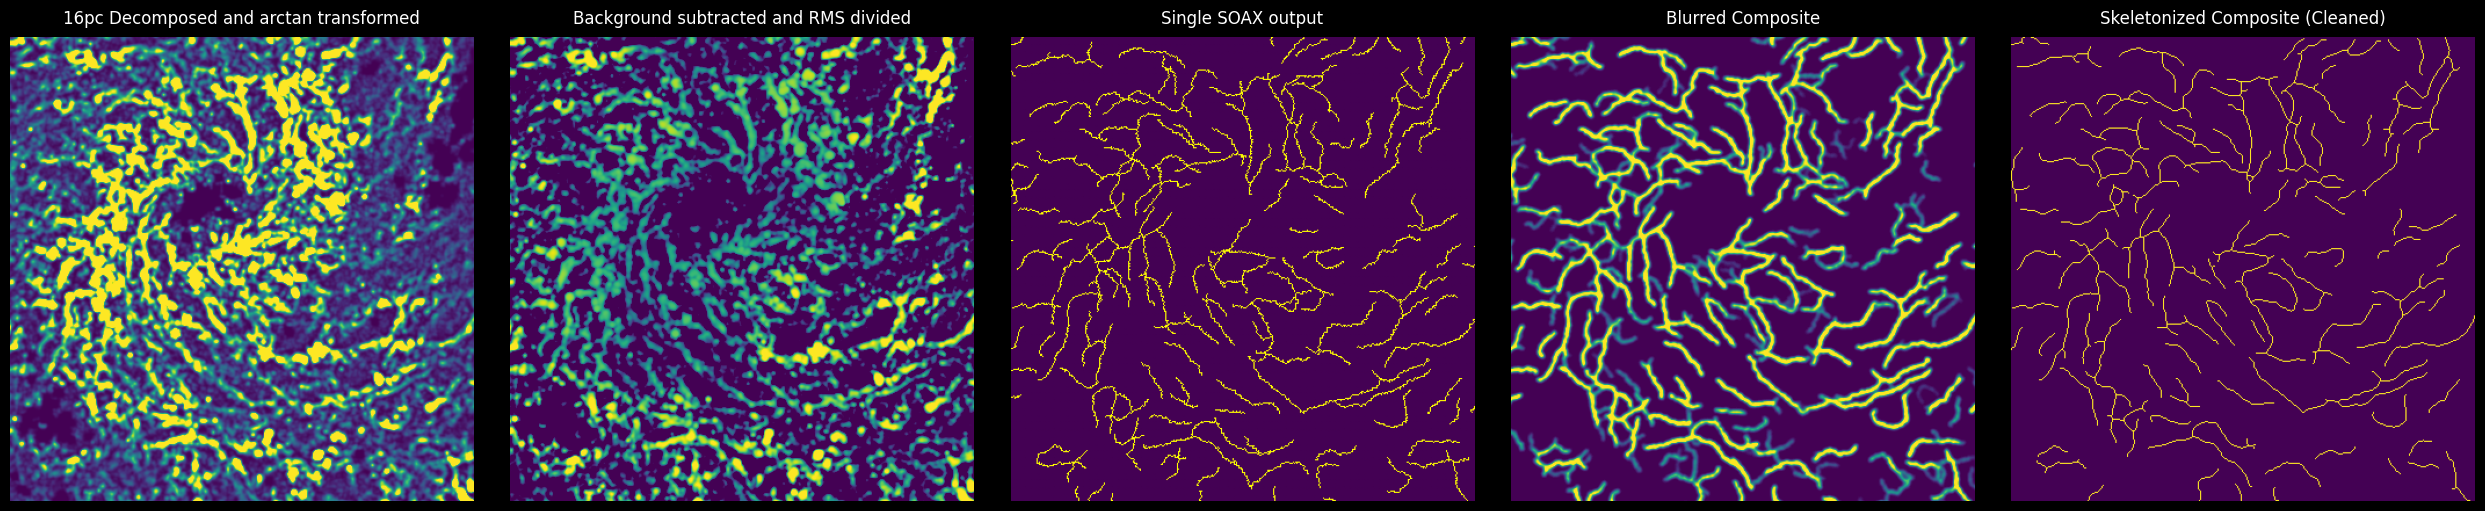

In [45]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from matplotlib.colors import ListedColormap
import cv2
from skimage.morphology import skeletonize
import AnalysisFuncs as AF

# --- Configuration ---
label = "ngc0628"
scale = 16
size = 400
start_x = 700
start_y = 900

# --- File Paths ---
base_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W"
CDD_path = f"{base_path}/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
Processed_image_path = f"{base_path}/BkgSubDivRMS/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_BkgSubDivRMS.fits"
Interpolated_path = f"{base_path}/SoaxOutput/16pc/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_Blocked--ridge0.02375--stretch2.250.fits"
blurred_path = f"{base_path}/Composites/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_CompositeBlur.fits"

# --- Load FITS Data ---
def load_fits_data(path):
    with fits.open(path) as hdul:
        return hdul[0].data

# --- Binary Check ---
def is_binary(image):
    return len(np.unique(image)) <= 2

# --- Image Paths and Descriptions ---
image_paths = [
    (CDD_path, "16pc Decomposed and arctan transformed"),
    (Processed_image_path, "Background subtracted and RMS divided"),
    (Interpolated_path, "Single SOAX output"),
    (blurred_path, "Blurred Composite"),
]

# --- Load and Process Images ---
images = [load_fits_data(path) for path, _ in image_paths]
binary_cmap = ListedColormap([(68/255, 1/255, 84/255), (1, 1, 0)])

# --- Prepare Skeleton ---
final_image = images[3]  # Blurred image
cropped = final_image[start_y:start_y + size, start_x:start_x + size]
cropped_norm = np.clip(cropped, np.percentile(cropped, 2), np.percentile(cropped, 98))
cropped_norm = (255 * (cropped_norm - cropped_norm.min()) / (cropped_norm.max() - cropped_norm.min())).astype(np.uint8)
_, binary_cv = cv2.threshold(cropped_norm, 128, 255, cv2.THRESH_BINARY)
binary_bool = binary_cv > 0
skeleton = skeletonize(binary_bool)

# --- Clean Skeleton (Remove Small Components) ---
img = skeleton.astype(np.uint8)
labels, stats, num_labels = AF.identify_connected_components(img)
small_areas = AF.sort_label_id(num_labels, stats, 50)
for label_id in small_areas:
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    img[top:top+height, left:left+width] = 0
skeleton = img.astype(np.uint8)

# --- Plot ---
fig, axes = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True)
fig.patch.set_facecolor('black')

# Plot first four images
for ax, image, (path, title) in zip(axes[:4], images, image_paths):
    cropped = image[start_y:start_y + size, start_x:start_x + size]
    
    if "SOAX" in title or is_binary(image):
        ax.imshow(cropped, cmap=binary_cmap, origin="lower", vmin=0, vmax=1)
    else:
        norm_image = np.clip(cropped, np.percentile(image, 2), np.percentile(image, 98))
        ax.imshow(norm_image, cmap="viridis", origin="lower")
    
    ax.axis("off")
    ax.set_facecolor("black")
    ax.set_title(title, color='white', loc='center', pad=10)

# Plot cleaned skeleton
axes[4].imshow(skeleton, cmap="viridis", origin='lower')
axes[4].axis("off")
axes[4].set_facecolor("black")
axes[4].set_title("Skeletonized Composite (Cleaned)", color='white', loc='center', pad=10)

# --- Save and Show ---
plt.savefig("process_figure_black_row_with_skeleton_centered_titles.png", dpi=300, facecolor='black', bbox_inches='tight')
plt.show()


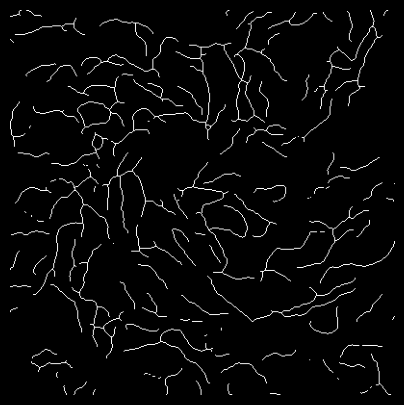

In [7]:
import cv2
from skimage.morphology import skeletonize

# Threshold and skeletonize using OpenCV
final_image = load_fits_data(blurred_path)
cropped = final_image[start_y:start_y + size, start_x:start_x + size]

# Normalize the image to 8-bit for OpenCV
cropped_norm = np.clip(cropped, np.percentile(cropped, 2), np.percentile(cropped, 98))
cropped_norm = (255 * (cropped_norm - cropped_norm.min()) / (cropped_norm.max() - cropped_norm.min())).astype(np.uint8)

# Apply fixed threshold using OpenCV (e.g., 128)
_, binary_cv = cv2.threshold(cropped_norm, 128, 255, cv2.THRESH_BINARY)

# Convert to boolean for skeletonization
binary_bool = binary_cv > 0

# Skeletonize
skeleton = skeletonize(binary_bool)

# Plot the skeleton image
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor('black')
ax.imshow(skeleton, cmap='gray', origin='lower')
ax.axis('off')
ax.set_facecolor("black")

plt.savefig("skeletonized_cv2.png", dpi=300, facecolor='black', bbox_inches='tight')
plt.show()


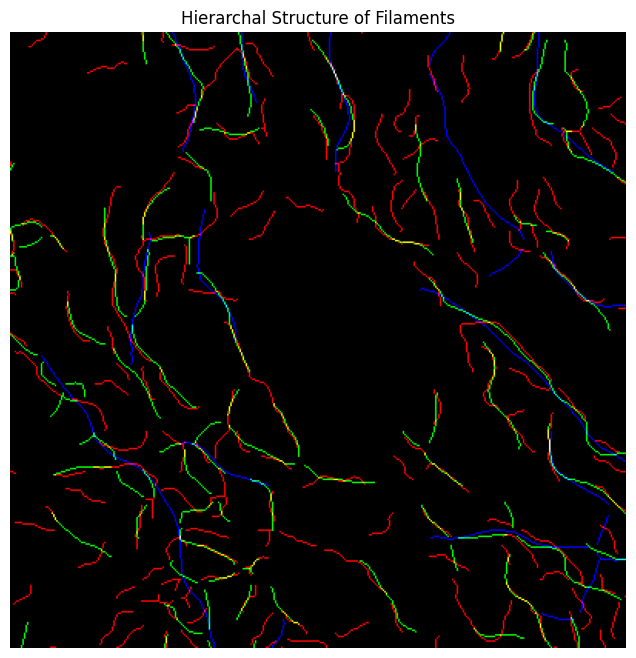

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

# Load the three FITS files
image_r_data = fits.getdata(r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc1672\Composites\ngc1672_JWST_F770W_starsub_CDDss0032pc_Composite_0.15.fits")
image_g_data = fits.getdata(r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc1672\Composites\ngc1672_JWST_F770W_starsub_CDDss0064pc_Composite_0.15.fits")
image_b_data = fits.getdata(r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc1672\Composites\ngc1672_JWST_F770W_starsub_CDDss0128pc_Composite_0.15.fits")

# image_r_data = fits.getdata(r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc1672\SyntheticMap\SyntheticMap_32pc.fits")
# image_g_data = fits.getdata(r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc1672\SyntheticMap\SyntheticMap_64pc.fits")
# image_b_data = fits.getdata(r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\ngc1672\SyntheticMap\SyntheticMap_128pc.fits")
size = 400
start_x = 800
start_y = 900

# Check if all images have the same dimensions
if image_r_data.shape != image_g_data.shape or image_g_data.shape != image_b_data.shape:
    raise ValueError("All images must have the same dimensions.")

# Normalize the images to fit in the range [0, 255]
def normalize(image):
    image_min = np.min(image)
    image_max = np.max(image)
    return ((image - image_min) / (image_max - image_min) * 255).astype(np.uint8)

image_r = normalize(image_r_data)
image_g = normalize(image_g_data)
image_b = normalize(image_b_data)

# Create an empty array for the combined image with 3 color channels
height, width = image_r.shape
combined_image = np.zeros((height, width, 3), dtype=np.uint8)

# Assign the red, green, and blue channels
combined_image[..., 0] = image_r  # Red channel
combined_image[..., 1] = image_g  # Green channel
combined_image[..., 2] = image_b  # Blue channel

# Display the combined image
plt.figure(figsize=(8, 8))
plt.imshow(combined_image[start_y:start_y + size,start_x:start_x + size])
plt.axis('off')
plt.title('Hierarchal Structure of Filaments')
plt.show()


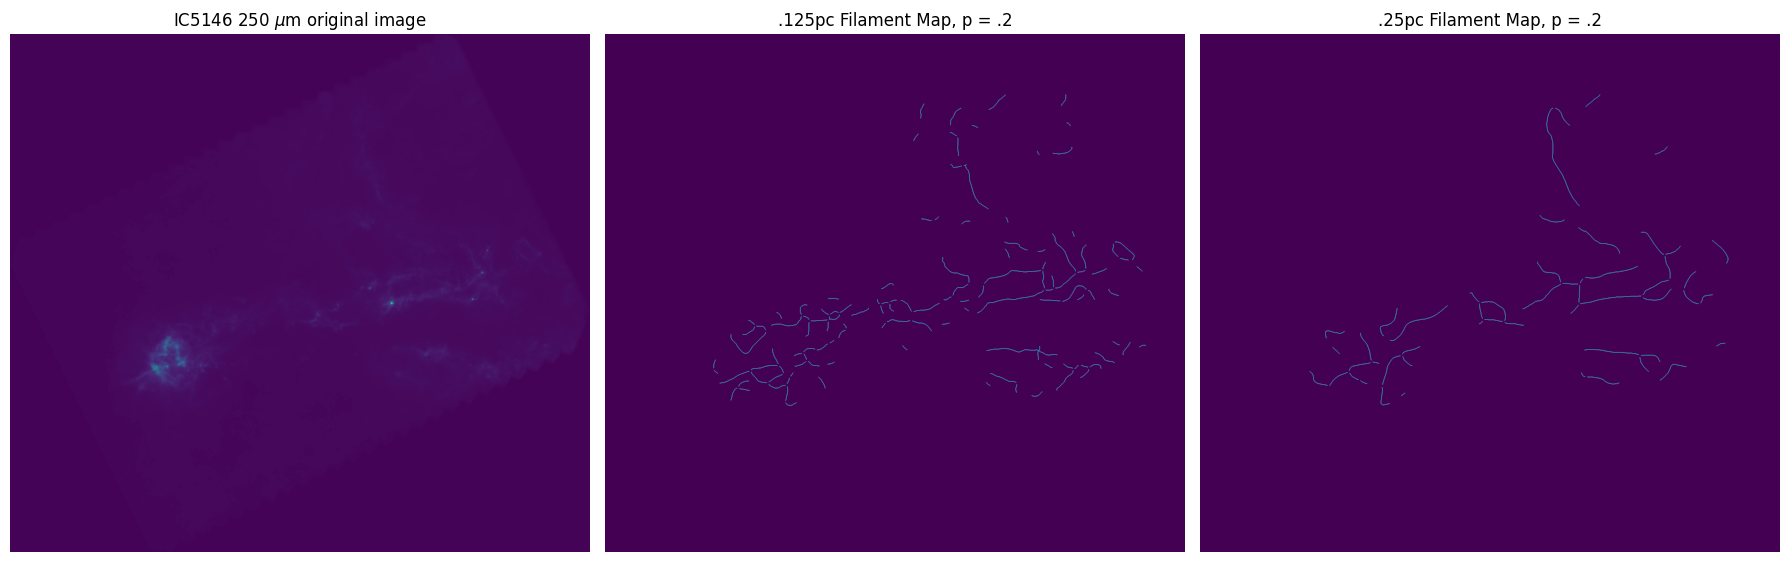

<Figure size 640x480 with 0 Axes>

In [11]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Paths to the FITS files
file_path_1 = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\OriginalImages\IC5146_Herschel_PSW.fits"
file_path_2 = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\IC5146\Composites\IC5146_Herschel_PSW_CDDss0.125pc_Composite_0.2.fits"
file_path_3 = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\IC5146\Composites\IC5146_Herschel_PSW_CDDss0.25pc_Composite_0.2.fits"
file_path_4 = r"C:\Users\HP\Documents\JHU_Academics\Research\FilPHANGS\IC5146\Composites\IC5146_Herschel_PSW_CDDss00.5pc_Composite_0.2.fits"

# Function to load and normalize FITS data
def load_fits_data(file_path, n, normalize):
    with fits.open(file_path) as hdul:
        image_data = hdul[n].data

    # Replace NaNs with 0 and normalize the image
    image_data = np.nan_to_num(image_data)
    if normalize:
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))
    return image_data

# Load the three images
image1 = load_fits_data(file_path_1, 1, False)
image2 = load_fits_data(file_path_2, 0, True)
image3 = load_fits_data(file_path_3, 0, True)
image4 = load_fits_data(file_path_4, 0, True)

# Display the images side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust for three images

# First image
axes[0].imshow(image1, origin='lower')  
axes[0].axis('off')  # Turn off axes
axes[0].set_title(r"IC5146 250 $\mu$m original image")

# Second image
axes[1].imshow(image2, origin='lower')  
axes[1].axis('off')  # Turn off axes
axes[1].set_title(".125pc Filament Map, p = .2")

# Third image
axes[2].imshow(image3, origin='lower')  
axes[2].axis('off')  # Turn off axes
axes[2].set_title(".25pc Filament Map, p = .2")

plt.tight_layout()
plt.show()


# axes[3].imshow(image4, origin='lower')  # Third image
# axes[3].axis('off')  # Turn off axes

plt.tight_layout()
plt.show()


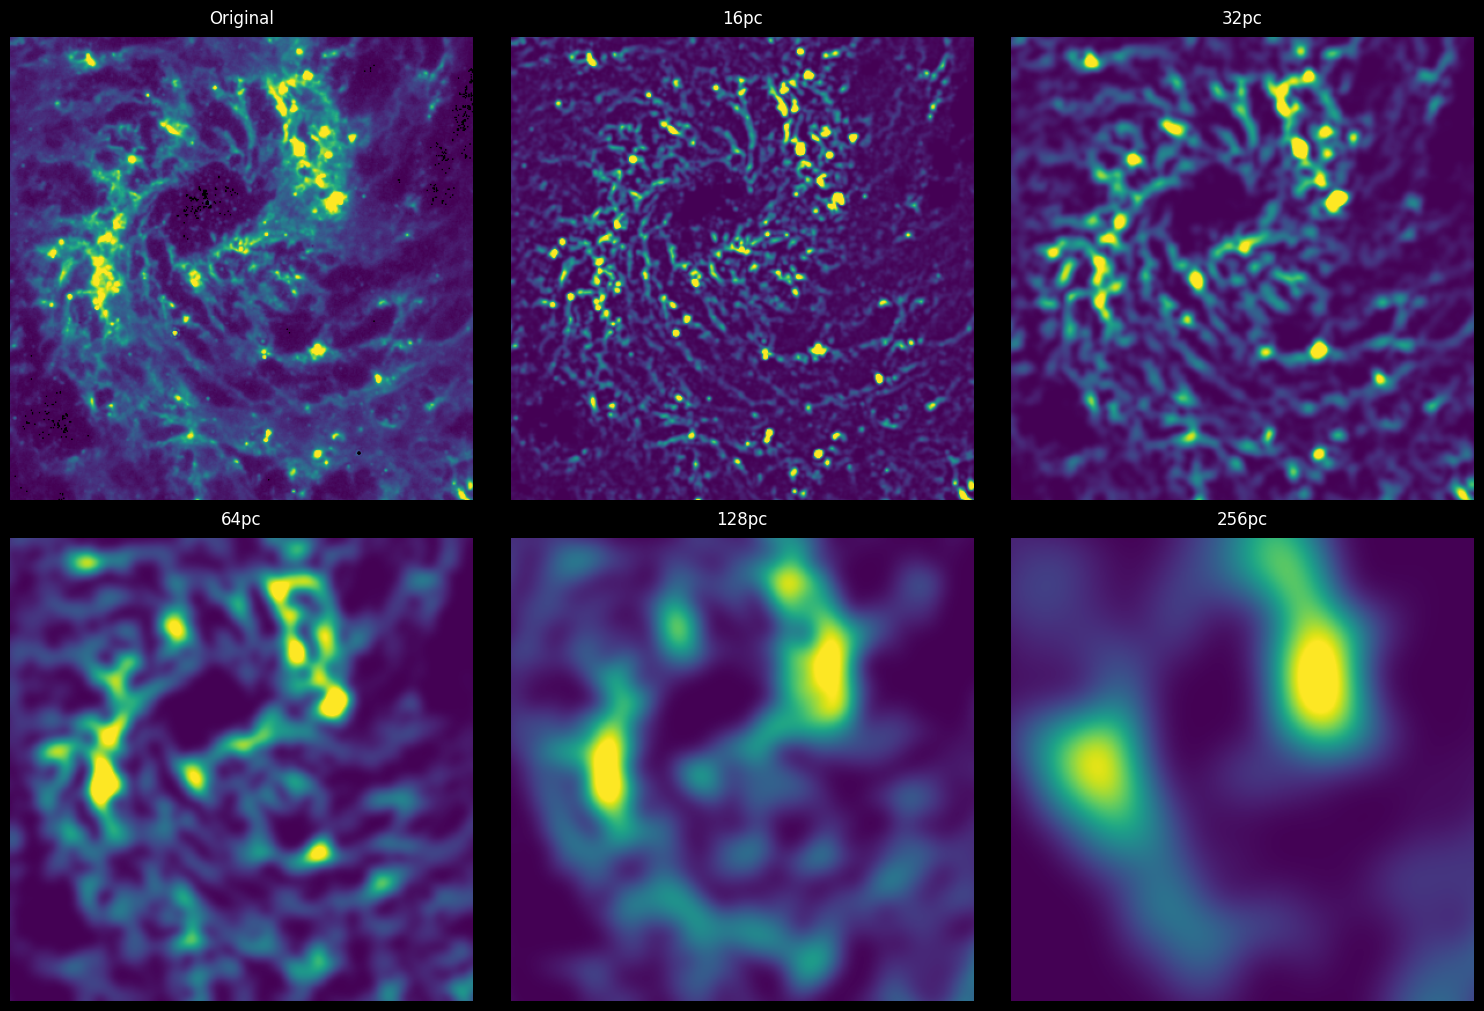

In [46]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

# Define file paths and corresponding titles
image_info = [
    ("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/FilPHANGS_Data/OriginalImages/ngc0628_F770W_JWST_Emission_starsub.fits", "Original"),
    ("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits", "16pc"),
    ("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0032pc.fits", "32pc"),
    ("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc.fits", "64pc"),
    ("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0128pc.fits", "128pc"),
    ("/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0256pc.fits", "256pc")
]

# Load FITS data
def load_fits_data(path):
    with fits.open(path) as hdul:
        return hdul[0].data

# Cropping parameters
size = 400
start_x = 700
start_y = 900

# Load all images
images = [load_fits_data(path) for path, _ in image_info]

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
fig.patch.set_facecolor('black')

# Plot the images with centered titles
for ax, image, (_, title) in zip(axes.flat, images, image_info):
    cropped = image[start_y:start_y + size, start_x:start_x + size]
    vmin = np.nanpercentile(cropped, 1)
    vmax = np.nanpercentile(cropped, 99)
    
    ax.imshow(cropped, cmap="viridis", origin="lower", vmin=vmin, vmax=vmax)
    ax.axis("off")
    ax.set_facecolor("black")
    ax.set_title(title, color='white', loc='center', pad=10)

# Save and display
plt.savefig("comparison_grid_centered_titles.png", dpi=300, facecolor='black', bbox_inches='tight')
plt.show()
